아래의 코드는 주어진 예측값(참고값)이 있을 때, 측정값의 bias 유무를 찾는 과정을 수행합니다.

다음과 같은 단계로 이루어져 있습니다:

> 1. 필요한 라이브러리와 사용자 정의 모듈을 불러옵니다.

> 2. 데이터 파일 경로를 설정합니다.

> 3. 결과를 저장하기 위한 함수를 정의합니다.

> 4. 훈련 데이터와 테스트 데이터를 불러옵니다.

> 5. 훈련 데이터를 사용하여 Configuration을 계산하고 저장합니다.

> 6. 시험용 데이터를 사용하여 Bias Monitoring을 실행합니다.

In [1]:
# 필요한 라이브러리들을 불러옵니다.
import os, sys
import numpy as np
import pandas as pd
from tqdm import tqdm

# 상위 디렉토리로 경로를 설정합니다.
sys.path.append(os.path.abspath('../'))

# 사용자 정의 모듈을 불러옵니다.
from classify_fault.set_config import calculate_variables_config
from classify_fault.bias_monitoring import *

In [2]:
data_path = '../data/TemperatureTrain.csv'
data_path2 = '../data/Temperature.csv'
config_save_path = '../config/example_config.json'

In [3]:
# 훈련 데이터와 테스트 데이터를 불러옵니다.
train_data = pd.read_csv(data_path, index_col=[0])
test_data = pd.read_csv(data_path2, index_col=[0])
tag_list = train_data.columns.to_list()
test_tag_list = ['temp5Bias']

In [4]:
train_data[tag_list].head()

,temp5
DateTime,
2022-08-01 00:00:00,1220.54
2022-08-01 00:10:00,1210.31
2022-08-01 00:20:00,1206.14
2022-08-01 00:30:00,1200.39
2022-08-01 00:40:00,1204.22


In [5]:
test_data[test_tag_list].head()

,temp5Bias
DateTime,
2023-01-01 00:00:00,1192.58
2023-01-01 00:01:00,1193.04
2023-01-01 00:02:00,1193.46
2023-01-01 00:03:00,1192.96
2023-01-01 00:04:00,1190.98


In [6]:
# 훈련 데이터를 사용하여 Configuration을 계산합니다.
config = calculate_variables_config(tag_list=tag_list, data=train_data[tag_list].values)
average = config[tag_list[0]]['statistic']['mean']
stdev = config[tag_list[0]]['statistic']['std']
# tracking_size = config[tag_list[0]]["tracking_size"]
tracking_size = 100

In [7]:
# 시험용 데이터를 사용하여 Univariate Monitoring을 실행합니다.
biases = []  # 편향 값을 저장할 리스트
bias = 0  # 초기 편향 값

# 트래킹 사이즈부터 테스트 데이터의 끝까지 반복
for i in range(tracking_size, len(test_data)):
    # 현재 인덱스를 기준으로 트래킹 사이즈만큼 이전의 테스트 데이터를 슬라이싱합니다.
    test_ = test_data[test_tag_list].values[i-tracking_size: i, :]
    # 참조 데이터를 생성합니다. 여기서는 평균값으로 구성된 리스트를 사용합니다.
    ref_ = [average for _ in range(len(test_))]
    # 현재 인덱스의 원래 값을 저장합니다.
    origin_value = test_data[test_tag_list].values[i][0]

    # 편향을 감지하는 함수를 호출하고 결과를 저장합니다.
    result = detect_bias(meas=test_, pred=ref_, std_train=stdev)
    # 결과에서 편향 값을 추출합니다.
    bias = result['result'][1]
    
    # 추출한 편향 값을 biases 리스트에 추가합니다.
    biases.append(bias)


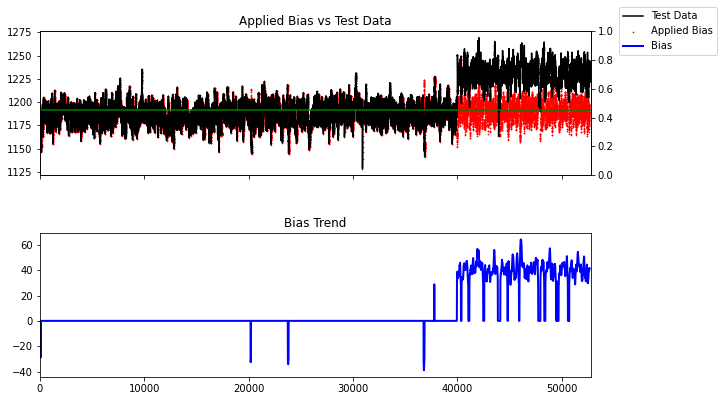

In [8]:
# 시각화
import matplotlib.pyplot as plt
test_data_list = list(test_data[test_tag_list].values.flatten())
applied_biases = [t - bias for t, bias in zip(test_data_list, biases)]

fig, ax = plt.subplots(2,1, figsize=(9, 6), sharex=True)
ax1, ax2 = ax[0], ax[1]
ax12 = ax1.twinx()

ax1.plot(test_data_list, c='k', label='Test Data')
ax1.scatter(x=np.arange(len(applied_biases)), y=applied_biases, 
            s=0.5, c='r', marker='x',
            label='Applied Bias')
ax1.axhline(y=average, c='g')
ax1.set_xlim(0, len(test_data_list))
ax1.set_title("Applied Bias vs Test Data")

ax2.plot(biases, c='b', label='Bias', linewidth=2)
ax2.set_title("Bias Trend")

fig.legend(loc='center', bbox_to_anchor=(1.07, 0.9))  # Set the legend location
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.95, hspace=0.4)
plt.show();